# Earthquake Data Analysis: Bangladesh Region

This notebook analyzes earthquake patterns in and around Bangladesh to identify any unusual seismic activity patterns.

## Objectives
- Analyze temporal trends in earthquake frequency
- Examine magnitude distribution changes over time
- Assess seismic energy release patterns
- Investigate spatial clustering and depth variations
- Detect aftershock sequences and earthquake swarms
- Evaluate changes in detection capabilities

## 1. Setup and Data Loading

Import necessary libraries for data analysis, visualization, and statistical testing.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import ks_2samp, poisson
from sklearn.neighbors import KernelDensity
import numpy as np

In [22]:
# Load earthquake data from CSV
df = pd.read_csv('data/query.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             1133 non-null   object 
 1   latitude         1133 non-null   float64
 2   longitude        1133 non-null   float64
 3   depth            1133 non-null   float64
 4   mag              1133 non-null   float64
 5   magType          1133 non-null   object 
 6   nst              475 non-null    float64
 7   gap              738 non-null    float64
 8   dmin             436 non-null    float64
 9   rms              1133 non-null   float64
 10  net              1133 non-null   object 
 11  id               1133 non-null   object 
 12  updated          1133 non-null   object 
 13  place            1133 non-null   object 
 14  type             1133 non-null   object 
 15  horizontalError  399 non-null    float64
 16  depthError       691 non-null    float64
 17  magError      

### Data Preprocessing

Convert temporal data to proper datetime format and extract year for time-series analysis.

In [23]:
# Convert time column to datetime, coercing errors
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Extract year for temporal analysis
df['year'] = df['time'].dt.year

### Geographic Filtering

Filter data to focus on Bangladesh and surrounding region:
- **Latitude range**: 18.5°N to 28.5°N
- **Longitude range**: 86°E to 94.5°E
- Includes ~2° margin around Bangladesh borders to capture nearby seismic activity

In [24]:
# Define region bounding box for Bangladesh and nearby areas
min_lat, max_lat = 18.5, 28.5
min_lon, max_lon = 86, 94.5

region_df = df[
    (df['latitude'].between(min_lat, max_lat)) &
    (df['longitude'].between(min_lon, max_lon))
].copy()

print("Total earthquakes in filtered region:", len(region_df))

Total earthquakes in filtered region: 1133


## 2. Data Validation

Verify that we're analyzing the correct geographic region by visualizing recent significant earthquakes.

**What to look for:**
- Earthquakes should cluster around Bangladesh and neighboring countries
- Verify the spatial extent matches expectations
- Check for any obvious data quality issues

In [25]:
# Visualize recent significant earthquakes (e.g., year 2025, magnitude >= 5)
filtered_data = region_df[(region_df['mag'] >= 5) & (region_df['year'] == 2025)]

fig = px.scatter_geo(filtered_data,
                     lat='latitude',
                     lon='longitude',
                     size='mag',
                     hover_name='place',
                     projection='natural earth',
                     title='Data Validation: Earthquakes (Mag >= 5) in 2025')
fig.update_traces(marker=dict(
    colorscale='Viridis',
    color=filtered_data['mag'],
    colorbar=dict(title='Magnitude'),
    showscale=True
))
fig.update_geos(showland=True, landcolor="LightGreen", showocean=True, oceancolor="LightBlue")
fig.show()

## 3. Temporal Trend Analysis

### 3.1 Earthquake Frequency Over Time

**Research Question:** Has the number of earthquakes changed significantly over time?

**What to look for:**
- **Upward trend**: Could indicate increased seismic activity or improved detection
- **Downward trend**: May suggest decreased activity or changes in reporting
- **Sudden spikes**: Could indicate aftershock sequences or earthquake swarms
- **Steady pattern**: Suggests consistent seismic activity or detection capability

**Interpretation notes:**
- Compare recent years against the long-term average
- Consider whether changes are gradual or abrupt
- Account for potential improvements in detection technology


Yearly earthquake counts:
 year
1985     2
1986    12
1987    13
1988    30
1989    17
1990    19
1991    24
1992    30
1993    17
1994    21
1995    22
1996    41
1997    22
1998    29
1999    20
2000    23
2001    30
2002    23
2003    27
2004    28
2005    29
2006    34
2007    28
2008    45
2009    27
2010    11
2011    30
2012    28
2013    30
2014    44
2015    61
2016    27
2017    23
2018    24
2019    31
2020    48
2021    43
2022    21
2023    34
2024    36
2025    29
dtype: int64


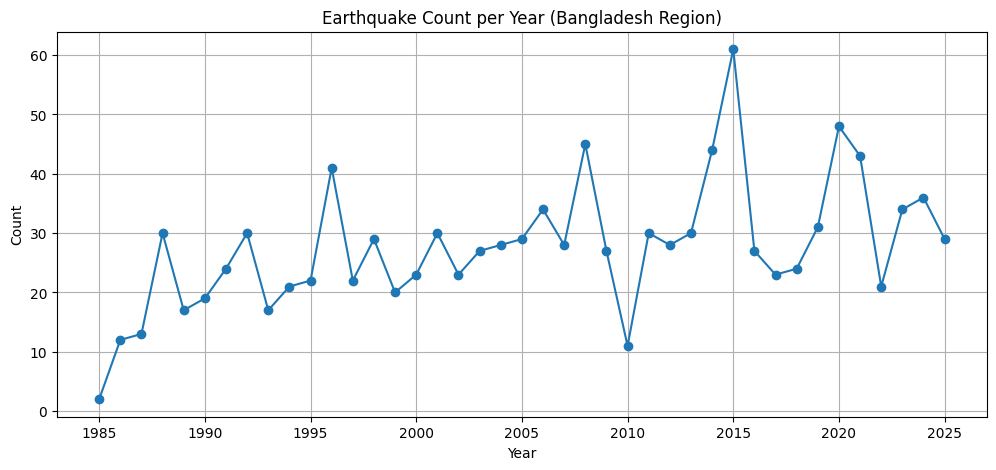

In [26]:
# Calculate and visualize yearly earthquake counts
yearly_counts = region_df.groupby('year').size()

print("\nYearly earthquake counts:\n", yearly_counts)

plt.figure(figsize=(12,5))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o')
plt.title("Earthquake Count per Year (Bangladesh Region)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(True)
plt.show()

## 4. Magnitude Distribution Analysis

### 4.1 Magnitude Ranges Over Time

**Research Question:** Has the distribution of earthquake magnitudes changed?

**What to look for:**
- **Increased proportion of larger quakes**: May indicate heightened seismic risk
- **More small earthquakes detected**: Could reflect improved sensor coverage
- **Shifts in magnitude bins**: Look for changes in the frequency of moderate (M4-5) vs strong (M5+) events
- **Consistent patterns**: Suggests stable detection and reporting

**Key magnitude thresholds:**
- M < 3: Minor (often not felt)
- M 3-4: Light (generally felt, rarely causes damage)
- M 4-5: Moderate (noticeable shaking, minor damage possible)
- M 5-6: Strong (can cause significant damage)
- M > 6: Major to great (serious damage potential)


Yearly earthquake counts by magnitude bins:
 year           1985  1986  1987  1988  1989  1990  1991  1992  1993  1994  \
magnitude_bin                                                               
(0, 3]            0     0     0     0     0     0     0     0     0     0   
(3, 4]            0     0     0     3     2     2     3     4     0     4   
(4, 5]            2     9    11    23    10    13    16    24    17    16   
(5, 6]            0     3     2     3     5     4     5     2     0     1   
(6, 8]            0     0     0     1     0     0     0     0     0     0   
(8, 10]           0     0     0     0     0     0     0     0     0     0   

year           ...  2016  2017  2018  2019  2020  2021  2022  2023  2024  2025  
magnitude_bin  ...                                                              
(0, 3]         ...     0     0     0     0     0     0     0     0     0     0  
(3, 4]         ...     4     1     5     3     5     5     2     3     2     2  
(4, 5]       

/var/folders/xt/8vlf86b12sj97ydvhg75641r0000gn/T/ipykernel_48215/1057575798.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



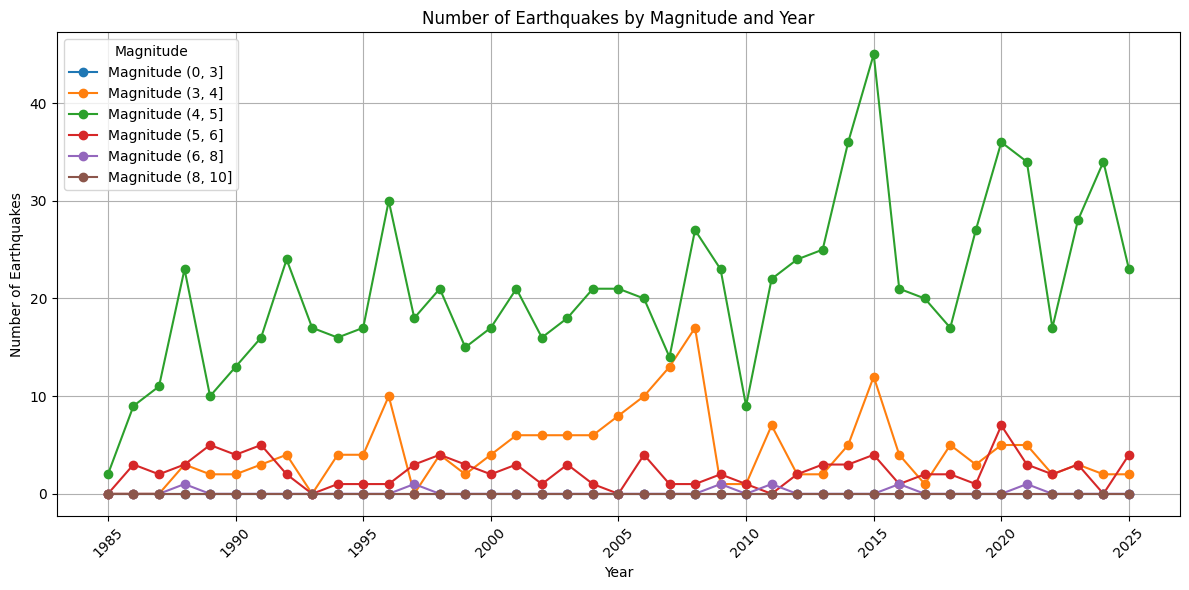

In [27]:
# Analyze earthquake counts by magnitude range and year
magnitude_bins = [0, 3, 4, 5, 6, 8, 10]
region_df['magnitude_bin'] = pd.cut(region_df['mag'], bins=magnitude_bins)
magnitude_yearly_counts = region_df.groupby(['magnitude_bin', 'year']).size().unstack(fill_value=0)

print("\nYearly earthquake counts by magnitude bins:\n", magnitude_yearly_counts)

plt.figure(figsize=(12, 6))
for mag_bin in magnitude_yearly_counts.index:
    plt.plot(magnitude_yearly_counts.columns, magnitude_yearly_counts.loc[mag_bin], marker='o', label=f'Magnitude {mag_bin}')
plt.title('Number of Earthquakes by Magnitude and Year')
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.grid()
plt.xticks(rotation=45)
plt.legend(title='Magnitude')
plt.tight_layout()
plt.show()

### 4.2 Magnitude Distribution Statistics

**What to look for:**
- **Mean/median changes**: Rising values suggest stronger earthquakes on average
- **Standard deviation**: Higher values indicate more variability in magnitudes
- **Maximum magnitude**: Track the strongest event each year
- **Outliers in boxplot**: Unusually strong or weak events for a given year

**Statistical significance:**
- Year-to-year variations are normal
- Look for persistent multi-year trends rather than single-year anomalies


Magnitude distribution stats per year:
          mean   50%       std  min  max
year                                    
1985  4.750000  4.75  0.353553  4.5  5.0
1986  4.808333  4.75  0.350216  4.3  5.4
1987  4.730769  4.80  0.311942  4.1  5.3
1988  4.700000  4.60  0.581911  4.0  6.9
1989  4.723529  4.60  0.559609  3.9  5.8
1990  4.594737  4.50  0.462450  3.8  5.3
1991  4.691667  4.70  0.502097  3.5  5.5
1992  4.420000  4.35  0.406329  3.6  5.3
1993  4.529412  4.60  0.266375  4.1  5.0
1994  4.485714  4.60  0.445293  3.7  5.8
1995  4.404545  4.40  0.407638  3.7  5.5
1996  4.312195  4.30  0.384834  3.6  5.4
1997  4.736364  4.50  0.531436  4.1  6.1
1998  4.506897  4.50  0.452715  3.8  5.6
1999  4.515000  4.40  0.424605  4.0  5.6
2000  4.373913  4.30  0.423425  3.7  5.5
2001  4.393333  4.30  0.425833  3.5  5.2
2002  4.334783  4.30  0.366319  3.8  5.1
2003  4.429630  4.30  0.503690  3.8  5.7
2004  4.300000  4.20  0.347478  3.6  5.4
2005  4.251724  4.30  0.388790  3.5  5.0
2006  4.370588  4

<Figure size 1200x600 with 0 Axes>

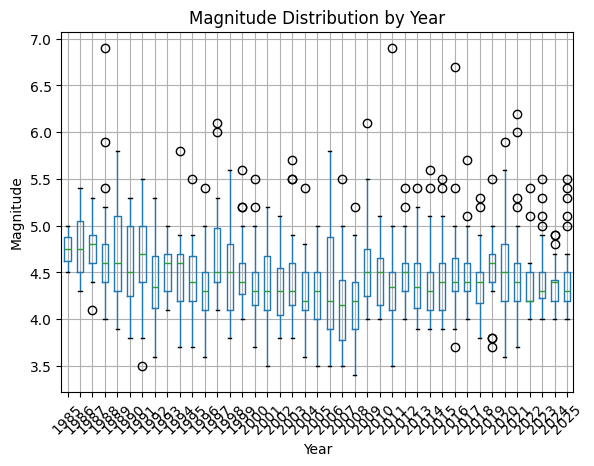

In [28]:
# Statistical summary and boxplot of magnitude distributions by year
mag_by_year = region_df.groupby('year')['mag']

print("\nMagnitude distribution stats per year:")
print(mag_by_year.describe()[['mean','50%','std','min','max']])

# Boxplot for visual comparison
plt.figure(figsize=(12,6))
region_df.boxplot(column='mag', by='year')
plt.title("Magnitude Distribution by Year")
plt.suptitle("")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.ylabel("Magnitude")
plt.show()

### 4.3 Geographic Distribution of Magnitudes

**What to look for:**
- **Spatial clustering**: Are strong earthquakes concentrated in specific areas?
- **Geographic patterns**: Identify active fault zones or subduction zones
- **Distribution changes**: Compare current patterns to historical data
- **Color intensity**: Darker/warmer colors indicate stronger magnitudes

In [29]:
# Map earthquake magnitude distribution across the region
fig = px.scatter_geo(region_df,
                     lat='latitude',
                     lon='longitude',
                     size='mag',
                     hover_name='place',
                     projection='natural earth',
                     title='Geographic Distribution of Earthquake Magnitudes')

fig.update_traces(marker=dict(
    colorscale='Viridis',
    color=region_df['mag'],
    colorbar=dict(title='Magnitude'),
    showscale=True
))
fig.update_geos(showland=True, landcolor="LightGreen", showocean=True, oceancolor="LightBlue")
fig.show()

## 5. Seismic Energy Analysis

### Total Energy Release

**Research Question:** Has the total seismic energy released changed over time?

**Background:** 
- Earthquake magnitude is logarithmic: each unit increase represents ~31.6× more energy
- One M7 earthquake releases more energy than thousands of M4 earthquakes
- Energy formula: log₁₀(E) ≈ 1.5M + 4.8 (Gutenberg-Richter relation)

**What to look for:**
- **Energy spikes**: Usually caused by one or more large earthquakes
- **Long-term trends**: Gradual increases may indicate heightened tectonic stress
- **Recent vs. historical**: Compare current year against multi-year average
- **Dominant events**: A single large quake can dominate annual energy totals

**Interpretation:**
- High energy with low event count = few large earthquakes
- High energy with high event count = many moderate earthquakes or a major event


Total seismic energy per year (Joules):
 year
1985    2.350076e+12
1986    2.420119e+13
1987    1.677545e+13
1988    1.484080e+15
1989    6.797388e+13
1990    2.512666e+13
1991    4.902406e+13
1992    2.159336e+13
1993    9.655813e+12
1994    4.046697e+13
1995    1.906602e+13
1996    2.182128e+13
1997    1.720084e+14
1998    3.797554e+13
1999    2.959704e+13
2000    2.141907e+13
2001    2.037778e+13
2002    9.931435e+12
2003    5.180016e+13
2004    1.434490e+13
2005    9.227611e+12
2006    5.713050e+13
2007    1.881202e+13
2008    1.462902e+13
2009    1.145367e+14
2010    6.282209e+12
2011    1.422588e+15
2012    2.288595e+13
2013    2.345895e+13
2014    3.707731e+13
2015    4.495908e+13
2016    7.254808e+14
2017    3.339710e+13
2018    1.621587e+13
2019    2.660255e+13
2020    1.035993e+14
2021    2.120498e+14
2022    1.501773e+13
2023    3.117064e+13
2024    1.132744e+13
2025    3.422305e+13
Name: energy_joules, dtype: float64


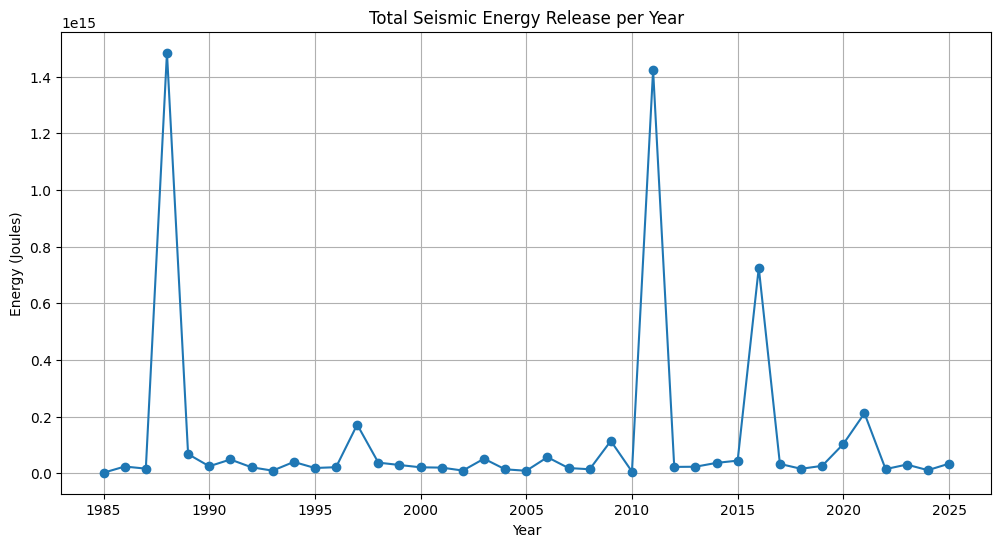

In [30]:
# Calculate and plot total seismic energy release per year
# Using the Gutenberg–Richter energy relation: log10(E) ≈ 1.5M + 4.8
region_df['energy_joules'] = 10 ** (1.5 * region_df['mag'] + 4.8)

energy_by_year = region_df.groupby('year')['energy_joules'].sum()

print("\nTotal seismic energy per year (Joules):\n", energy_by_year)

plt.figure(figsize=(12,6))
plt.plot(energy_by_year.index, energy_by_year.values, marker='o')
plt.title("Total Seismic Energy Release per Year")
plt.xlabel("Year")
plt.ylabel("Energy (Joules)")
plt.grid(True)
plt.show()

## 6. Depth Distribution Analysis

### Earthquake Depth Patterns

**Research Question:** Are earthquakes occurring at different depths than usual?

**Background:**
- **Shallow (<70 km)**: Crustal earthquakes, typically most damaging
- **Intermediate (70-300 km)**: Subduction zone earthquakes
- **Deep (>300 km)**: Deep subduction zone earthquakes, rarely felt at surface

**What to look for:**
- **Depth shifts**: Changes in average/median depth may indicate different seismic sources
- **Shallow clustering**: More shallow quakes can mean higher surface damage risk
- **Depth range expansion**: New depth ranges may indicate activation of different fault systems
- **Outliers**: Unusually deep or shallow events warrant investigation

**Regional context:**
- Bangladesh region experiences mainly shallow to intermediate depth earthquakes
- Himalayan collision zone produces mostly shallow crustal quakes
- Subduction zones (if present) produce deeper events


Depth distribution stats per year:
           mean     50%        std    min      max
year                                              
1985  30.850000  30.850  25.667976  12.70   49.000
1986  53.125000  46.200  24.035206  17.50   94.800
1987  44.653846  47.600  12.802904  27.30   74.300
1988  44.860000  33.000  16.808528  28.90   89.200
1989  43.676471  33.800  21.018371   5.80  104.500
1990  58.421053  33.000  41.257034  33.00  170.200
1991  46.170833  33.000  17.780142  33.00   85.300
1992  46.460000  33.000  24.387767  29.30  129.400
1993  48.576471  33.000  27.789533  27.70  130.900
1994  34.776190  33.000  11.299155  10.00   76.200
1995  41.845455  33.000  17.443698  20.00  100.000
1996  44.221951  33.000  24.256118  17.80  129.200
1997  45.859091  33.950  17.876019  33.00  100.000
1998  41.848276  33.000  20.352547  22.30  100.000
1999  42.835000  33.000  16.032016  10.00   72.800
2000  35.952174  33.000  13.915618  14.00   92.700
2001  33.046667  33.000  12.619955  10.00   60

<Figure size 1200x500 with 0 Axes>

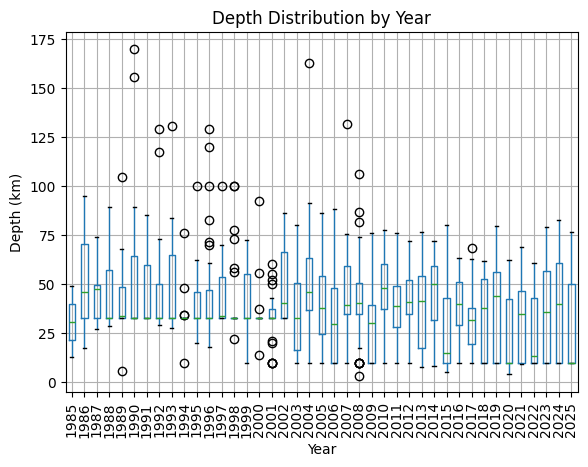

In [31]:
# Analyze depth distribution statistics and visualize with boxplots
depth_by_year = region_df.groupby('year')['depth']

print("\nDepth distribution stats per year:")
print(depth_by_year.describe()[['mean','50%','std','min','max']])

plt.figure(figsize=(12,5))
region_df.boxplot(column='depth', by='year')
plt.title("Depth Distribution by Year")
plt.suptitle("")
plt.xlabel("Year")
plt.xticks(rotation=90)
plt.ylabel("Depth (km)")
plt.show()

## 7. Spatial and Temporal Clustering

### 7.1 Kernel Density Estimation (KDE)

**Research Question:** Are earthquakes clustering differently in space this year compared to previous years?

**What to look for:**
- **Density hotspots**: Areas of concentrated seismic activity
- **New clusters**: Emergence of activity in previously quiet areas
- **Cluster migration**: Shifts in activity centers over time
- **Intensity changes**: Stronger colors indicate higher earthquake density

**Interpretation:**
- Tight clustering may indicate:
  - Earthquake swarms (many similar-sized events)
  - Aftershock sequences (following a large mainshock)
  - Localized tectonic stress concentration
- Diffuse patterns suggest regional tectonic activity

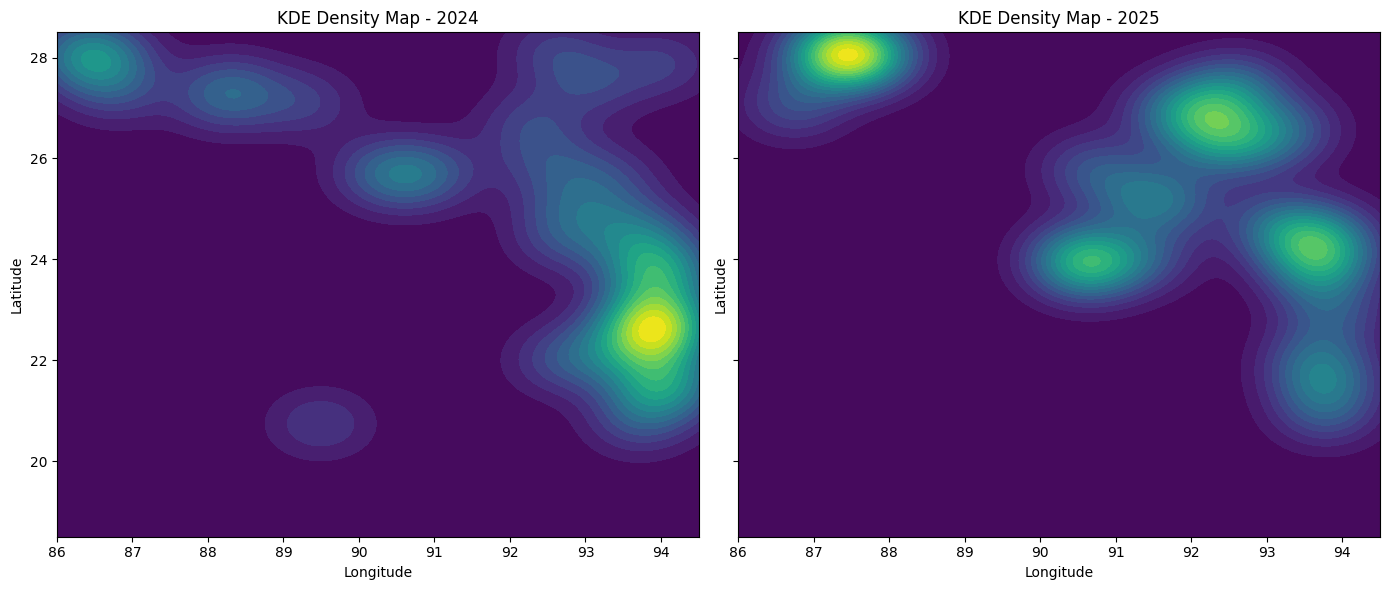

In [32]:
# Compare spatial density patterns between consecutive years using KDE
# Extract coordinates for KDE
coords = region_df[['longitude', 'latitude']].values

# Create a KDE model for each year to compare clustering
kde_years = {}
for y in region_df['year'].unique():
    pts = region_df[region_df['year'] == y][['longitude', 'latitude']].values
    if len(pts) > 2: # KDE requires at least 3 points
        kde_years[y] = KernelDensity(bandwidth=0.5, kernel='gaussian').fit(pts)

# Plot KDE heatmap for the most recent year vs the prior year
current_year = region_df['year'].max()
previous_year = current_year - 1

def plot_kde(year, ax):
    if year not in kde_years:
        ax.text(0.5, 0.5, f"No KDE for {year}", ha='center')
        ax.set_title(f"KDE Density Map - {year}")
        return

    kde = kde_years[year]
    lon_lin = np.linspace(min_lon, max_lon, 200)
    lat_lin = np.linspace(min_lat, max_lat, 200)
    xx, yy = np.meshgrid(lon_lin, lat_lin)
    grid = np.vstack([xx.ravel(), yy.ravel()]).T

    zz = np.exp(kde.score_samples(grid)).reshape(xx.shape)
    ax.contourf(xx, yy, zz, levels=20)
    ax.set_title(f"KDE Density Map - {year}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
plot_kde(previous_year, axs[0])
plot_kde(current_year, axs[1])
plt.tight_layout()
plt.show()

## 8. Earthquake Sequences

### 8.1 Aftershock Detection

**Research Question:** Are there significant aftershock sequences following major earthquakes?

**Background:**
- Aftershocks: Smaller earthquakes following a mainshock (typically within days to weeks)
- Follow Omori's law: frequency decreases with time after mainshock
- Typically occur within ~1-2 fault lengths of mainshock

**Detection criteria:**
- **Mainshock threshold**: M ≥ 5.0
- **Temporal window**: 7 days after mainshock
- **Spatial window**: ±0.5° latitude/longitude (~55 km)

**What to look for:**
- **Number of sequences**: More sequences may indicate increased large earthquake activity
- **Aftershock productivity**: Number of aftershocks per mainshock
- **Magnitude differences**: Typical aftershocks are 1-2 magnitudes smaller than mainshock
- **Duration**: Extended sequences may indicate continued stress release

In [33]:
# Identify mainshocks and their associated aftershock sequences
MAINSHOCK_MAG = 5.0
mainshocks = region_df[region_df['mag'] >= MAINSHOCK_MAG]

aftershock_sequences = []
for idx, main in mainshocks.iterrows():
    # Define a temporal and spatial window to search for aftershocks
    time_window = (region_df['time'] > main['time']) & (region_df['time'] <= main['time'] + pd.Timedelta(days=7))
    lat_window = region_df['latitude'].between(main['latitude'] - 0.5, main['latitude'] + 0.5)
    lon_window = region_df['longitude'].between(main['longitude'] - 0.5, main['longitude'] + 0.5)

    window = region_df[time_window & lat_window & lon_window]

    if not window.empty:
        aftershock_sequences.append((main, window))

print(f"Detected {len(aftershock_sequences)} potential aftershock sequences.")
for main, aftershocks in aftershock_sequences:
    print(f"\nMainshock: {main['time']} Mag {main['mag']:.2f} at ({main['latitude']:.2f}, {main['longitude']:.2f})")
    print(f"  └─ Found {len(aftershocks)} aftershocks.")

Detected 40 potential aftershock sequences.

Mainshock: 2025-11-21 04:38:28.765000+00:00 Mag 5.40 at (23.81, 90.65)
  └─ Found 2 aftershocks.

Mainshock: 2021-11-25 23:45:41.752000+00:00 Mag 6.20 at (22.82, 93.51)
  └─ Found 2 aftershocks.

Mainshock: 2021-07-07 03:15:24.246000+00:00 Mag 5.30 at (25.96, 90.35)
  └─ Found 1 aftershocks.

Mainshock: 2021-04-28 02:33:01.489000+00:00 Mag 5.00 at (26.75, 92.51)
  └─ Found 3 aftershocks.

Mainshock: 2021-04-28 02:21:26.212000+00:00 Mag 6.00 at (26.78, 92.46)
  └─ Found 4 aftershocks.

Mainshock: 2021-04-05 15:19:57.976000+00:00 Mag 5.20 at (27.19, 88.94)
  └─ Found 1 aftershocks.

Mainshock: 2020-08-27 12:07:15.628000+00:00 Mag 5.30 at (23.16, 93.33)
  └─ Found 1 aftershocks.

Mainshock: 2020-07-17 16:33:53.474000+00:00 Mag 5.10 at (23.12, 93.31)
  └─ Found 1 aftershocks.

Mainshock: 2020-06-21 22:40:52.633000+00:00 Mag 5.60 at (23.14, 93.29)
  └─ Found 2 aftershocks.

Mainshock: 2020-04-16 11:45:23.960000+00:00 Mag 5.90 at (22.80, 94.03)
  

### 8.2 Earthquake Swarm Detection

**Research Question:** Are there earthquake swarms (clusters without a dominant mainshock)?

**Background:**
- Swarms differ from aftershock sequences: no single dominant mainshock
- Events of similar magnitude occurring close together in space and time
- Can indicate fluid migration, volcanic activity, or slow slip events

**Method:** DBSCAN clustering algorithm
- Groups earthquakes based on spatial and temporal proximity
- No predefined number of clusters required
- Identifies outliers (isolated events)

**Parameters:**
- **eps (0.4)**: Maximum distance between earthquakes in a cluster
- **min_samples (4)**: Minimum earthquakes to form a cluster

**What to look for:**
- **Cluster sizes**: Larger clusters (>5 events) may be swarms
- **Spatial tightness**: Swarms typically occur in very localized areas
- **Magnitude distribution**: Swarms have similar-sized events (unlike aftershock sequences)
- **Temporal concentration**: Events occur over days to weeks

Potential swarm clusters found:
cluster
0       7
1    1061
2       6
3       8
dtype: int64


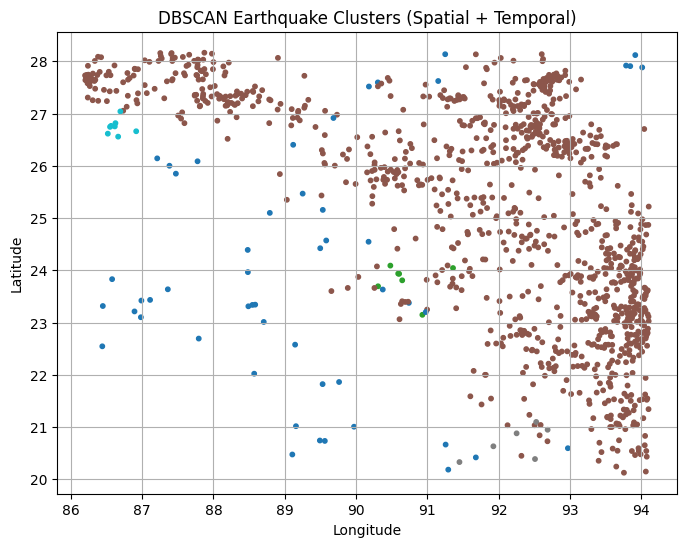

In [34]:
# Use DBSCAN to identify potential earthquake swarms
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Prepare data for clustering (spatial + temporal dimensions)
X = region_df[['latitude', 'longitude']].copy()
X['time_ordinal'] = region_df['time'].astype(np.int64) // 10**9  # convert ns to seconds
X_scaled = StandardScaler().fit_transform(X)

# Run DBSCAN (eps and min_samples may need tuning)
db = DBSCAN(eps=0.4, min_samples=4).fit(X_scaled)
region_df['cluster'] = db.labels_

# Identify and report potential swarm clusters (clusters with more than 5 events)
swarm_clusters = region_df[region_df['cluster'] != -1].groupby('cluster').size()
swarm_clusters = swarm_clusters[swarm_clusters > 5]

print("Potential swarm clusters found:")
print(swarm_clusters)

# Plot clusters on a map
plt.figure(figsize=(8,6))
plt.scatter(region_df['longitude'], region_df['latitude'], c=region_df['cluster'], cmap='tab10', s=10)
plt.title("DBSCAN Earthquake Clusters (Spatial + Temporal)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

### 8.3 Inter-Event Time Analysis

**Research Question:** Are earthquakes occurring closer together in time?

**What to look for:**
- **Shorter inter-event times**: May indicate:
  - Heightened seismic activity
  - Aftershock sequences
  - Earthquake swarms
- **Distribution shifts**: Compare current year histogram against previous years
- **Median changes**: Lower median = events occurring more frequently

**Interpretation:**
- Normal tectonic regions: Inter-event times vary widely
- Active periods: Shorter times, leftward histogram shift
- Quiet periods: Longer times, rightward histogram shift
- Exponential distribution is typical for earthquake occurrence

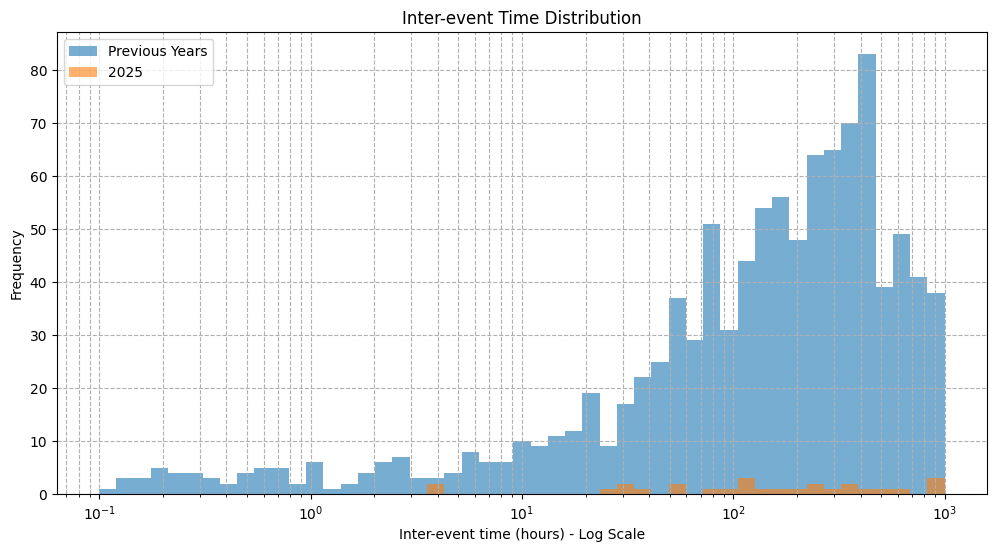

Median inter-event time (previous years): 191.08226666666667
Median inter-event time (2025): 149.43259444444445


In [35]:
# Compare inter-event time distributions between current and previous years
# Sort by time to calculate differences correctly
region_df = region_df.sort_values('time')

# Compute inter-event time deltas in hours
region_df['delta_hours'] = region_df['time'].diff().dt.total_seconds() / 3600

# Separate current year from previous years
current_df = region_df[region_df['year'] == current_year]
previous_df = region_df[region_df['year'] < current_year]

plt.figure(figsize=(12,6))
plt.hist(previous_df['delta_hours'].dropna(), bins=np.logspace(np.log10(0.1), np.log10(1000), 50), alpha=0.6, label='Previous Years')
plt.hist(current_df['delta_hours'].dropna(), bins=np.logspace(np.log10(0.1), np.log10(1000), 50), alpha=0.6, label=f'{current_year}')
plt.gca().set_xscale("log")
plt.legend()
plt.xlabel("Inter-event time (hours) - Log Scale")
plt.ylabel("Frequency")
plt.title("Inter-event Time Distribution")
plt.grid(True, which="both", ls="--")
plt.show()

print("Median inter-event time (previous years):", previous_df['delta_hours'].median())
print(f"Median inter-event time ({current_year}):", current_df['delta_hours'].median())

## 9. Detection System Analysis

### 9.1 Minimum Detectable Magnitude

**Research Question:** Has the detection threshold changed over time?

**Why this matters:**
- Improved sensors detect smaller earthquakes
- Network expansion increases detection capability
- Apparent increase in earthquakes may be due to better detection, not more activity

**What to look for:**
- **Decreasing minimum magnitude**: Better detection capability over time
- **Stable minimum**: Consistent detection threshold
- **Sudden changes**: May indicate:
  - New seismic stations coming online
  - Network upgrades
  - Changes in reporting practices

**Interpretation:**
- If minimum magnitude drops while total counts rise → likely improved detection
- If minimum magnitude stable while counts rise → possibly real increase in activity

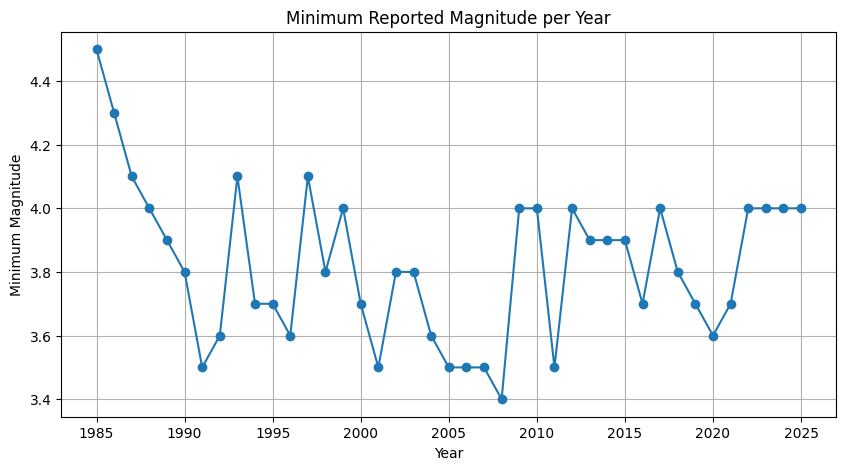

year
1985    4.5
1986    4.3
1987    4.1
1988    4.0
1989    3.9
1990    3.8
1991    3.5
1992    3.6
1993    4.1
1994    3.7
1995    3.7
1996    3.6
1997    4.1
1998    3.8
1999    4.0
2000    3.7
2001    3.5
2002    3.8
2003    3.8
2004    3.6
2005    3.5
2006    3.5
2007    3.5
2008    3.4
2009    4.0
2010    4.0
2011    3.5
2012    4.0
2013    3.9
2014    3.9
2015    3.9
2016    3.7
2017    4.0
2018    3.8
2019    3.7
2020    3.6
2021    3.7
2022    4.0
2023    4.0
2024    4.0
2025    4.0
Name: mag, dtype: float64


In [36]:
# Track minimum reported magnitude per year to assess detection capability
min_mag_by_year = region_df.groupby('year')['mag'].min()

plt.figure(figsize=(10,5))
plt.plot(min_mag_by_year.index, min_mag_by_year.values, marker='o')
plt.title("Minimum Reported Magnitude per Year")
plt.xlabel("Year")
plt.ylabel("Minimum Magnitude")
plt.grid(True)
plt.show()

print(min_mag_by_year)

### 9.2 Network Coverage

**Research Question:** Has the number of reporting networks changed?

**What to look for:**
- **Increasing networks**: More stations = better detection and location accuracy
- **Stable networks**: Consistent reporting capability
- **Network expansion**: May explain apparent increases in earthquake counts

**Interpretation:**
- Correlation with earthquake counts suggests detection bias
- More networks typically means:
  - More small earthquakes detected
  - Better location accuracy
  - More reliable magnitude estimates

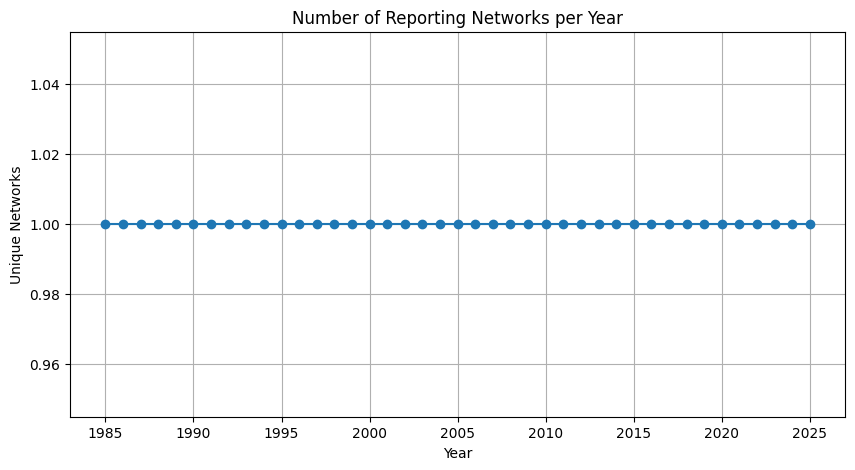

year
1985    1
1986    1
1987    1
1988    1
1989    1
1990    1
1991    1
1992    1
1993    1
1994    1
1995    1
1996    1
1997    1
1998    1
1999    1
2000    1
2001    1
2002    1
2003    1
2004    1
2005    1
2006    1
2007    1
2008    1
2009    1
2010    1
2011    1
2012    1
2013    1
2014    1
2015    1
2016    1
2017    1
2018    1
2019    1
2020    1
2021    1
2022    1
2023    1
2024    1
2025    1
Name: net, dtype: int64


In [37]:
# Track the number of unique reporting networks per year
station_counts = region_df.groupby('year')['net'].nunique()

plt.figure(figsize=(10,5))
plt.plot(station_counts.index, station_counts.values, marker='o')
plt.title("Number of Reporting Networks per Year")
plt.xlabel("Year")
plt.ylabel("Unique Networks")
plt.grid(True)
plt.show()

print(station_counts)

## 10. Statistical Significance Testing

### Formal Statistical Analysis

**Research Question:** Are observed changes statistically significant?

**Tests performed:**

1. **Poisson Test (Event Rate)**
   - Tests if current year's earthquake count differs significantly from historical average
   - Assumes earthquakes follow Poisson distribution
   - **Low p-value (<0.05)**: Significant change in frequency

2. **Kolmogorov-Smirnov Test (Magnitude Distribution)**
   - Compares magnitude distributions between periods
   - Tests if distributions are drawn from same underlying distribution
   - **Low p-value (<0.05)**: Significant shift in magnitude patterns

3. **Kolmogorov-Smirnov Test (Depth Distribution)**
   - Similar to magnitude test, but for earthquake depths
   - **Low p-value (<0.05)**: Significant change in depth characteristics

4. **Energy Comparison**
   - Compares total seismic energy release
   - Not a formal test, but provides context for magnitude changes

**Interpretation guidelines:**
- **p < 0.05**: Statistically significant (conventional threshold)
- **p < 0.01**: Highly significant
- **p > 0.05**: No significant difference detected
- **Note**: Statistical significance ≠ practical significance
  - Small changes can be statistically significant with enough data
  - Focus on effect size, not just p-values

In [38]:
# Perform statistical tests to assess significance of observed changes
print("\n------- Statistical Tests -------")

# Define previous years and current year dataframes
prev_years_df = region_df[region_df['year'] < current_year]
current_df = region_df[region_df['year'] == current_year]

# 1) Poisson test for event count change
lambda_prev = prev_years_df.groupby('year').size().mean()
count_current = len(current_df)

# Poisson probability of observing count_current given lambda_prev
p_value_poisson = poisson.pmf(count_current, lambda_prev)

print(f"Poisson test (count anomaly): p = {p_value_poisson:.4f}")
if p_value_poisson < 0.05:
    print(" -> Significant change in event count compared to historical average.")

# 2) KS test on magnitude distribution
if len(current_df) > 1 and len(prev_years_df) > 1:
    ks_stat, ks_p = ks_2samp(current_df['mag'], prev_years_df['mag'])
    print(f"KS test (magnitude distribution): p = {ks_p:.4f}")
    if ks_p < 0.05:
        print(" -> Significant difference in magnitude distribution.")
else:
    print("Not enough data for KS magnitude test.")

# 3) KS test on depth distribution
if len(current_df) > 1 and len(prev_years_df) > 1:
    ks_stat_d, ks_p_d = ks_2samp(current_df['depth'].dropna(), prev_years_df['depth'].dropna())
    print(f"KS test (depth distribution): p = {ks_p_d:.4f}")
    if ks_p_d < 0.05:
        print(" -> Significant difference in depth distribution.")
else:
    print("Not enough data for KS depth test.")

# 4) Energy comparison
if len(current_df) > 0:
    energy_current = current_df['energy_joules'].sum()
    energy_prev_avg = prev_years_df.groupby('year')['energy_joules'].sum().mean()
    print(f"Energy this year: {energy_current:.2e} J, Previous years' average: {energy_prev_avg:.2e} J")

print("--------------------------------")


------- Statistical Tests -------
Poisson test (count anomaly): p = 0.0713
KS test (magnitude distribution): p = 0.3950
KS test (depth distribution): p = 0.0028
 -> Significant difference in depth distribution.
Energy this year: 3.42e+13 J, Previous years' average: 1.27e+14 J
--------------------------------


## Summary and Recommendations

**After running all analyses, synthesize findings:**

1. **Temporal trends**: Are earthquake frequencies increasing, decreasing, or stable?
2. **Magnitude patterns**: Any shifts toward stronger or weaker events?
3. **Energy release**: Is cumulative energy release unusual?
4. **Spatial patterns**: New areas of activity or changes in existing patterns?
5. **Depth changes**: Any systematic shifts in earthquake depths?
6. **Clustering**: Evidence of swarms or aftershock sequences?
7. **Detection bias**: How much of the change is due to improved monitoring?
8. **Statistical significance**: Are changes meaningful or within normal variation?

**Key questions to answer:**
- Is the current seismic activity genuinely unusual?
- What are the potential hazard implications?
- Do changes reflect improved detection or real tectonic changes?
- Are there specific regions or magnitude ranges of concern?

**Next steps might include:**
- Focused analysis on specific time periods or regions showing anomalies
- Consultation with regional seismologists for context
- Hazard assessment updates if significant changes detected
- Continued monitoring of identified trends